In [20]:
!pip install langchain --quiet 
!pip install boto3 --quiet 
!pip install botocore --quiet 
!pip install Pillow --quiet 
%pip install anthropic IPython 


Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 12.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      + meson setup /tmp/pip-install-hxflz8bm/python-poppler_bf48876c7edc4651895150bfb5c897ea /tmp/pip-install-hxflz8bm/python-poppler_bf48876c7edc4651895150bfb5c897ea/.mesonpy-xmpxgdph -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=/tmp/pip-install-hxflz8bm/python-poppler_bf48876c7edc4651895150bfb5c897ea/.mesonpy-xmpxgdph/meson-python-native-file.ini
      The Meson build system
      Version: 1.4.0
      Source dir: /tmp/pip-install-hxflz8bm/python-poppler_bf48876c7edc4651895150bfb5c897ea
     

In [51]:
!pip install pymupdf
!pip install rapidocr-onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 25.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 24.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 18.0 MB/s eta 0:00:00


In [62]:
import boto3
import json
import time
import base64
from PIL import Image
import io
import os
from IPython.display import Image
from IPython.display import display
import ipywidgets as widgets
from langchain.document_loaders import PyMuPDFLoader
import fitz


In [57]:
#initialize bedrock client for given region and endpoint. Change as per your region

bedrock_client = boto3.client(
    service_name='bedrock-runtime', 
    region_name='us-east-1'
)

In [58]:
# Function to convert image to base64
def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        binary_data = image_file.read()
        base_64_encoded_data = base64.b64encode(binary_data)
        base64_string = base_64_encoded_data.decode('utf-8')
    return base64_string

In [88]:
local_pdf_file = './skyjack_manual.pdf'
# Load the PDF file
loader = PyMuPDFLoader(local_pdf_file)
pages = loader.load_and_split()

In [124]:
# Open the PDF document
doc = fitz.open(local_pdf_file)
dpi = 200
# Convert page 1 to image
page1 = doc.load_page(0)  # Page numbers start from 0
pix1 = page1.get_pixmap(dpi=dpi)
pix1.save("image1.jpg")

# Convert page 2 to image
page2 = doc.load_page(1)
pix2 = page2.get_pixmap(dpi=dpi)
pix2.save("image2.jpg")

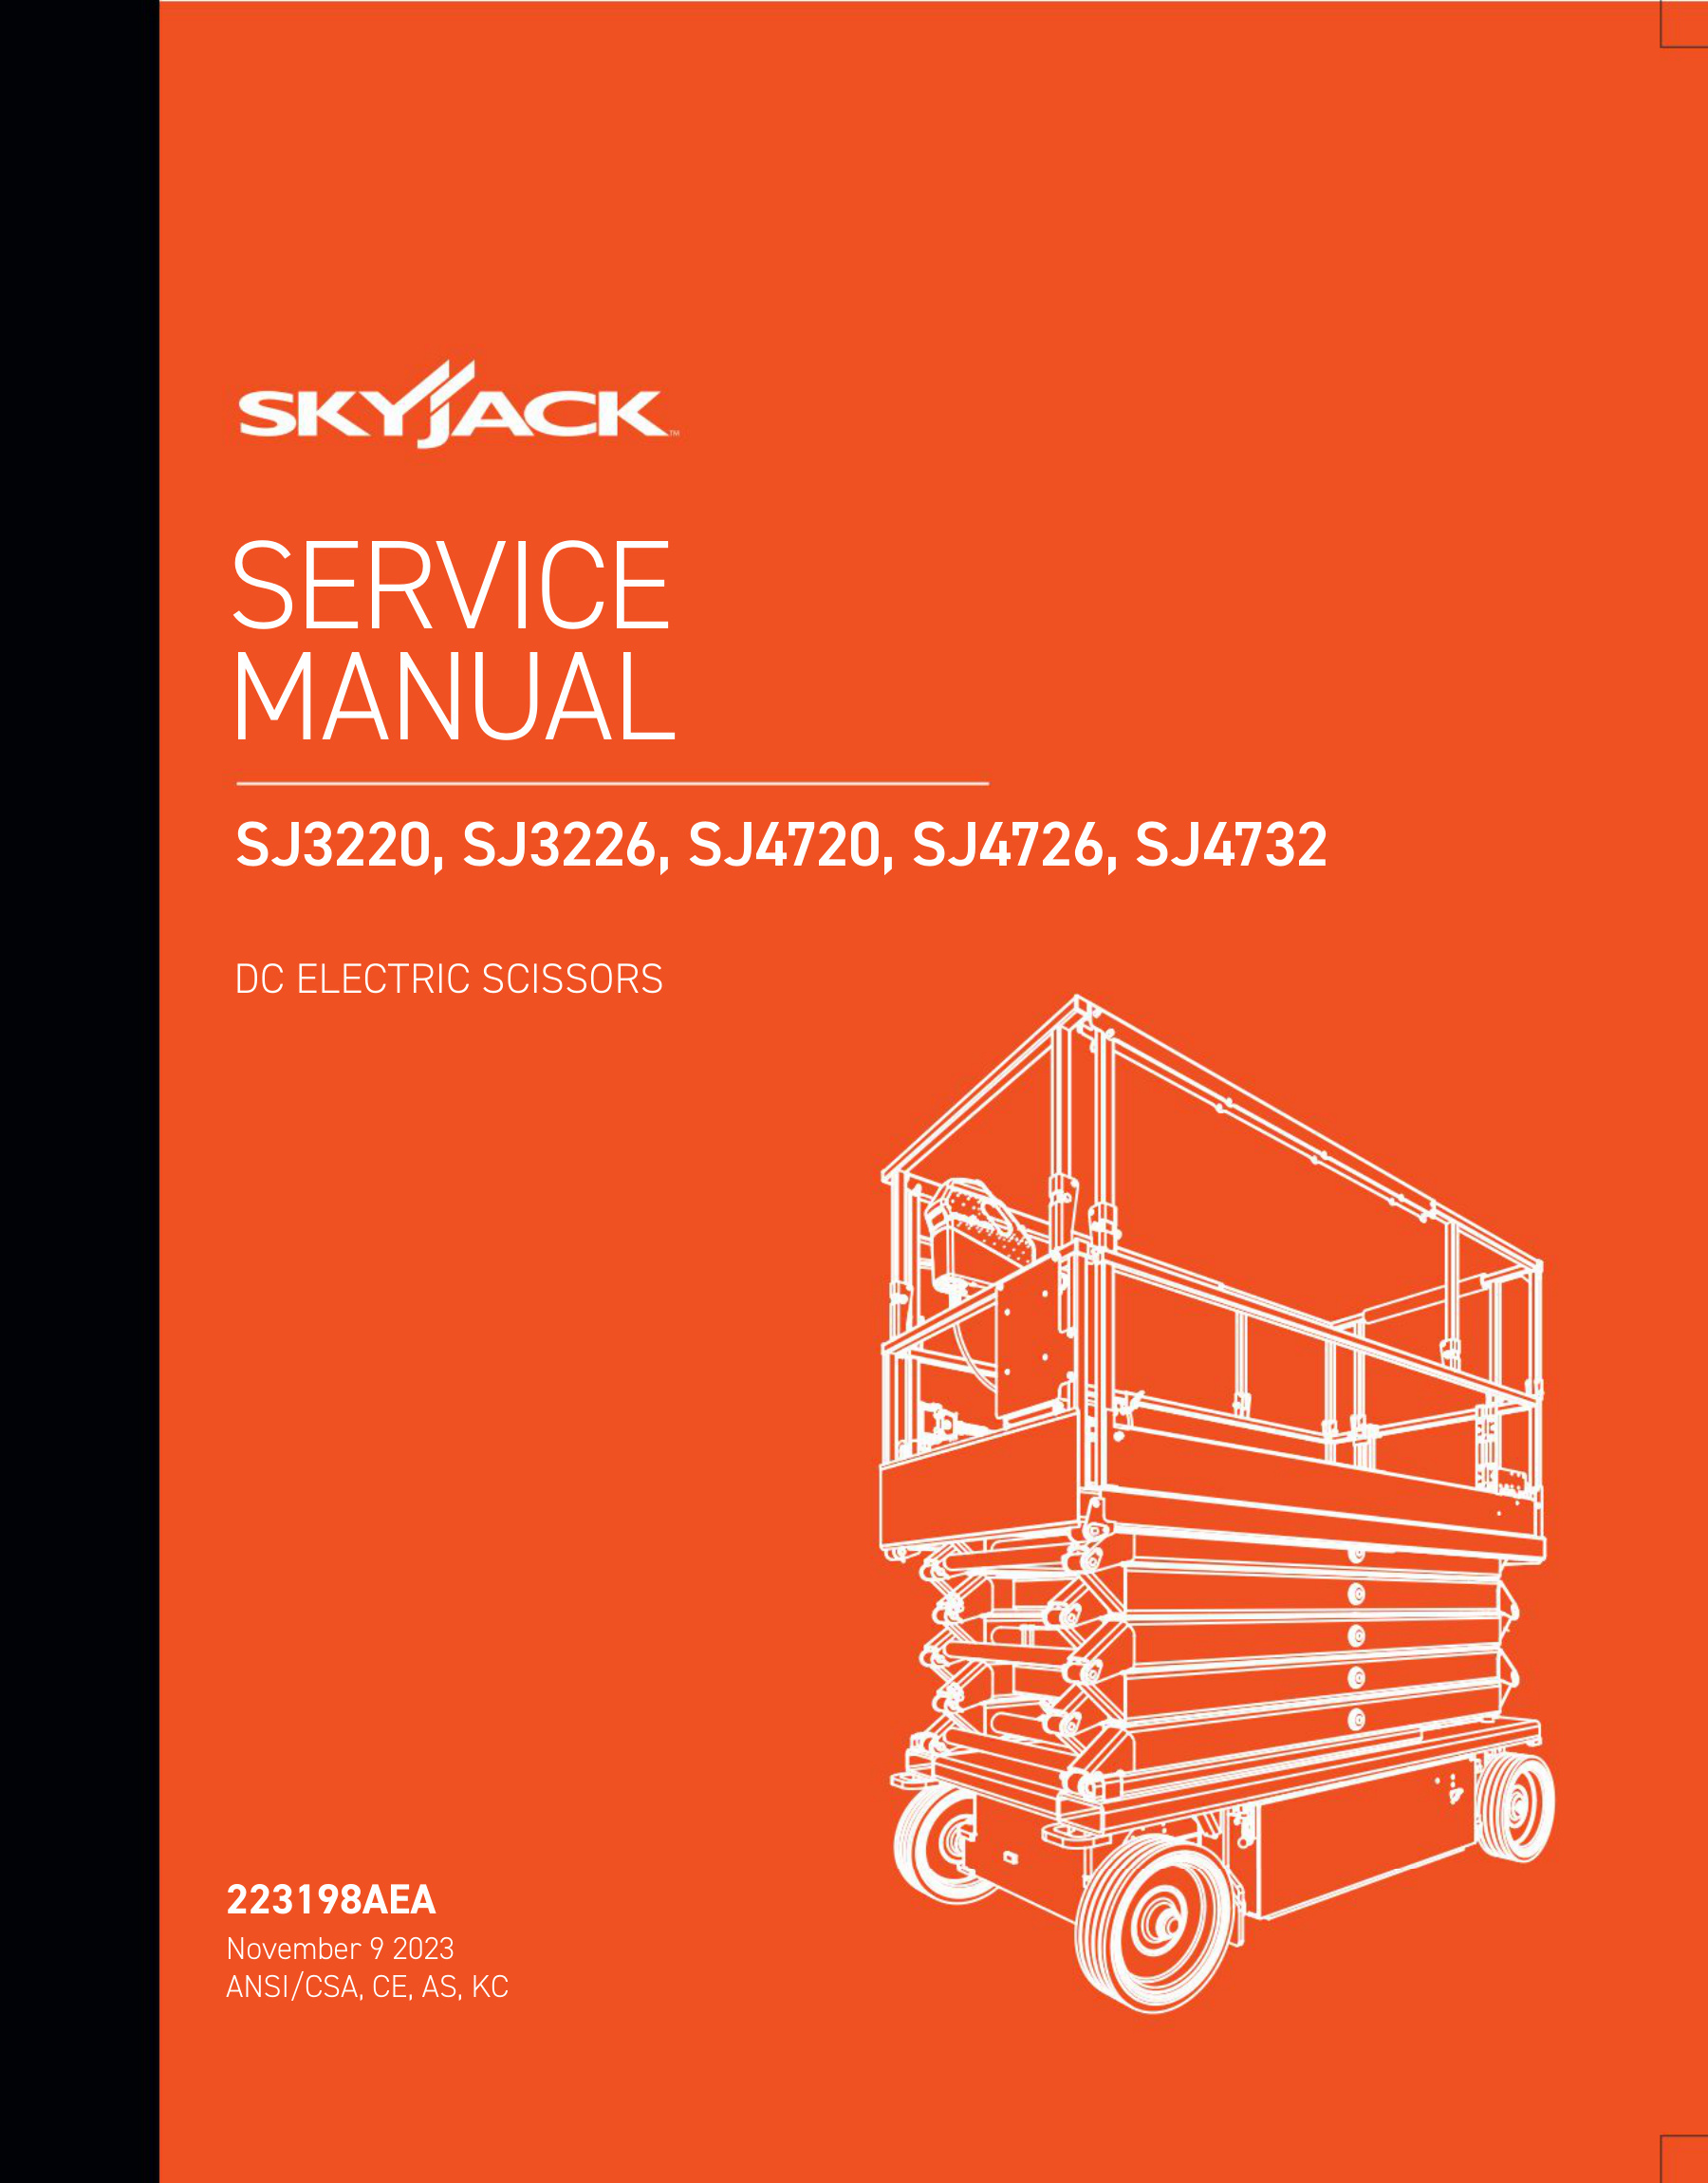

In [125]:
Image("image1.jpg") 



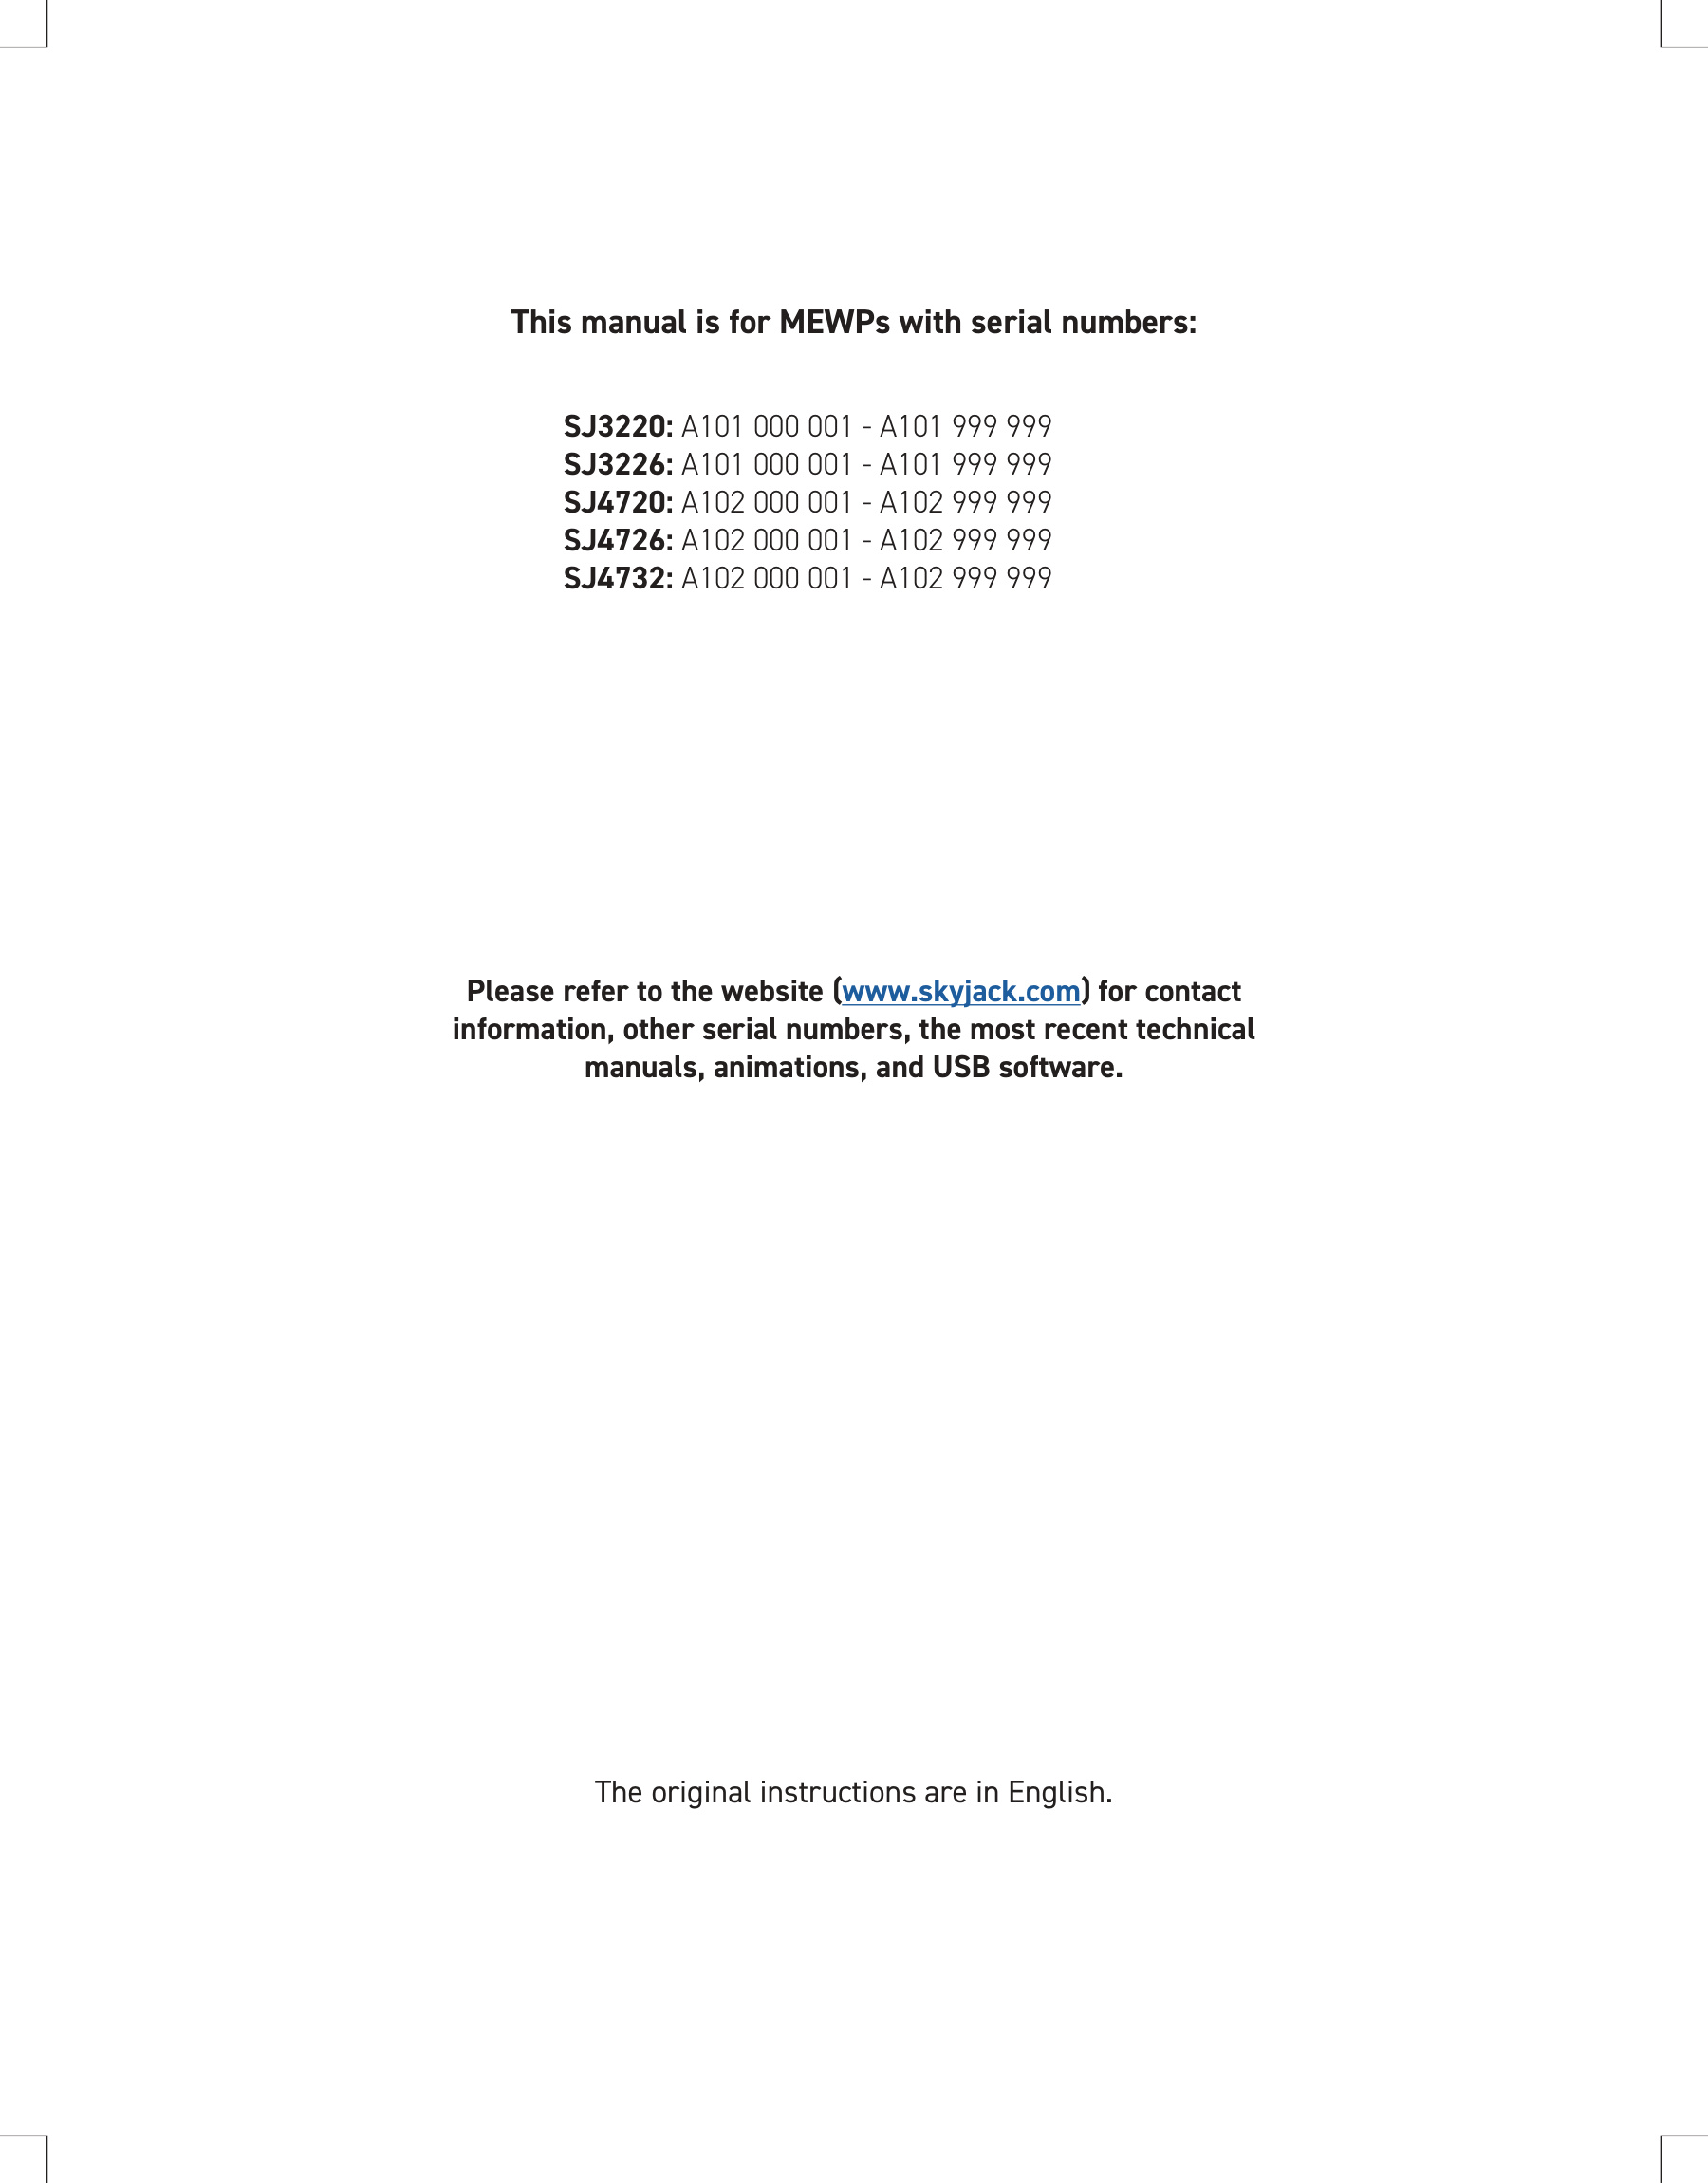

In [126]:
Image("image2.jpg") 

In [127]:
# based on a prompt.
#
# Arguments:
#   prompt: The text prompt to provide to the LLM.
#   llm_type: The name of the LLM to use'. 
#
# Returns:
#   The text generated by the LLM in response to the prompt.
#   
# This function:
# 1. Prints the llm_type for debugging.
# 2. Formats the prompt into the JSON payload expected by each LLM API.
# 3. Specifies the parameters for text generation like max tokens, temp.
# 4. Calls the Bedrock client to invoke the LLM model API. 
# 5. Parses the response to extract the generated text.
# 6. Returns the generated text string.

def interactWithLLM(prompt,image,modelId):
	
    # if llm_type == 'anthropic.claude-3-sonnet':
        print("**THE LLM TYPE IS -->" + model_id)
        body = json.dumps({
                          "anthropic_version": "bedrock-2023-05-31",
                          "max_tokens": 1000,
                          "temperature": 0,
                          "messages": [
                            {
                              "role": "user",
                              "content": [
                                {
                                  "type": "image",
                                  "source": {
                                    "type": "base64",
                                    "media_type": "image/jpeg",
                                    "data": image
                                  }
                                },
                                {
                                  "type": "text",
                                  "text": prompt
                                }
                              ]
                            }
                          ]
                        }) 
        # modelId = 'anthropic.claude-3-sonnet-20240229-v1:0' # change this to use a different version from the model provider
        accept = 'application/json'
        contentType = 'application/json'
        start_time = time.time()
        response = bedrock_client.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
         # Record the end time
        end_time = time.time()

        # Calculate the runtime
        runtime = end_time - start_time
        print(f"The runtime of the invoke_model was {runtime:.2f} seconds.")
        
        response_body = json.loads(response.get('body').read())
        response_text = response_body.get('content')[0]['text']

        return response_text

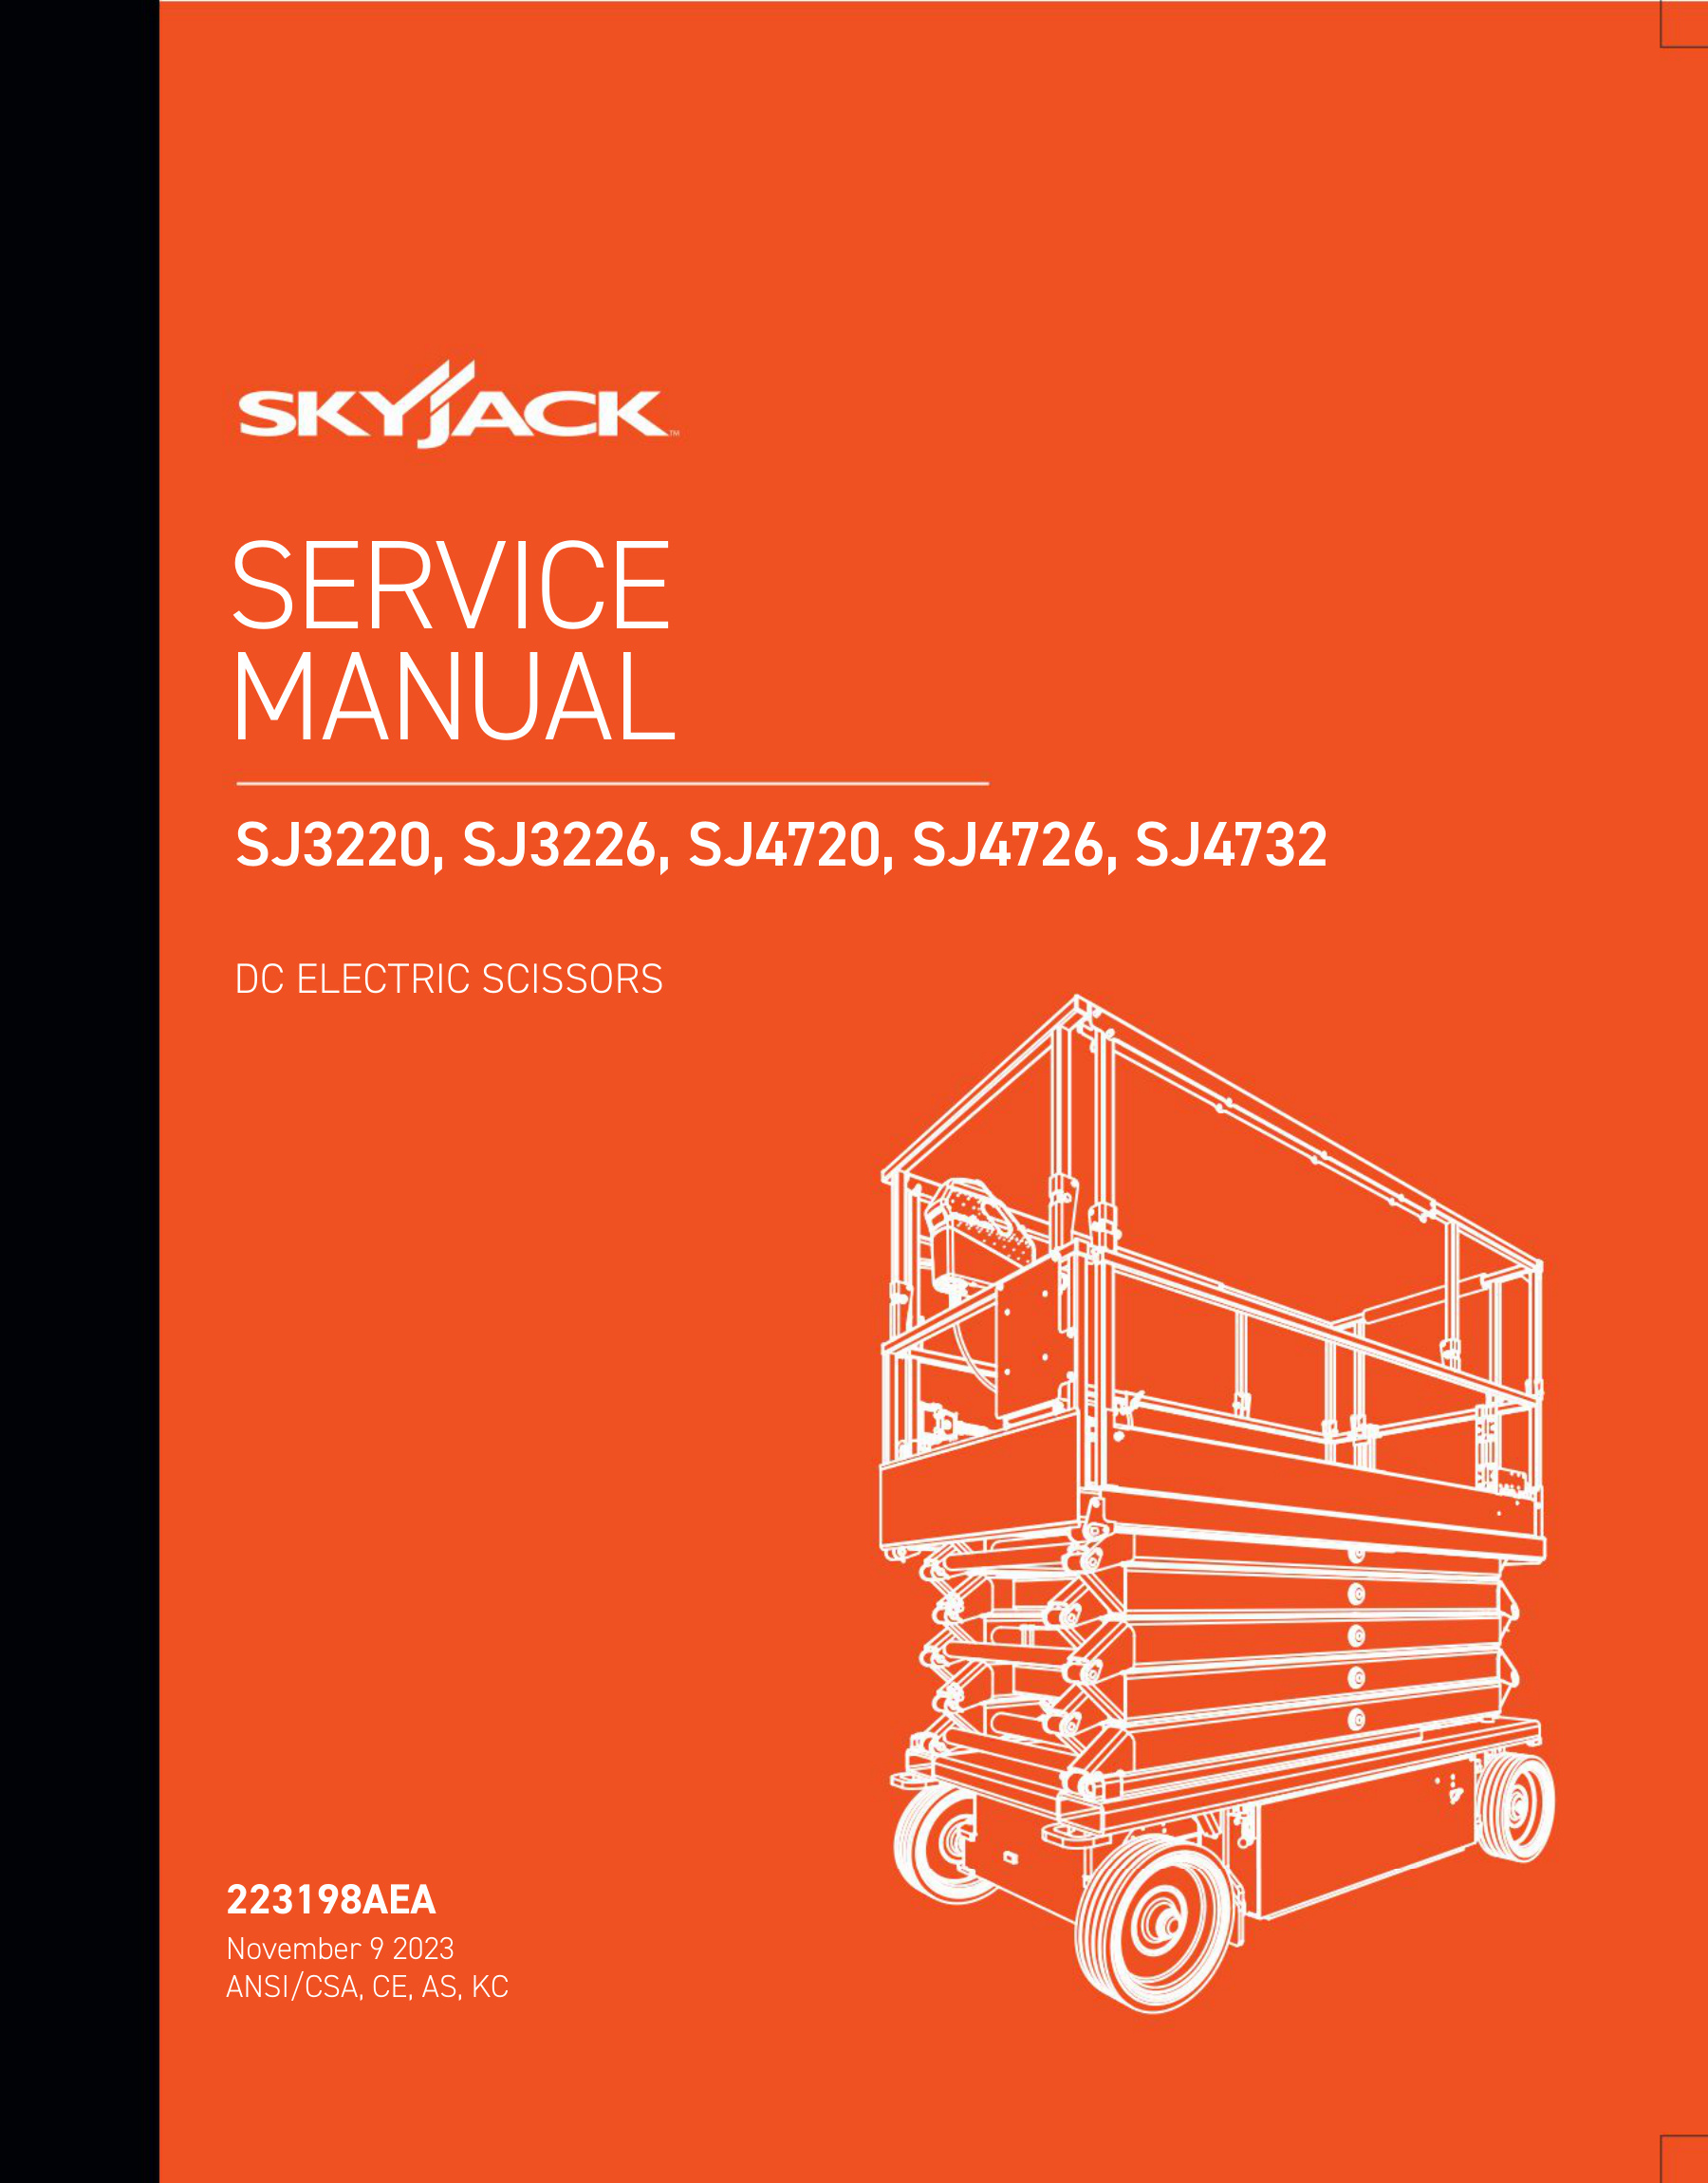

In [128]:
# Example usage
image_path = './image1.jpg'  # Specify the path to your image
base64_string = image_to_base64(image_path)
Image(filename=image_path) 

In [129]:
model_id = 'anthropic.claude-3-haiku-20240307-v1:0'

#model_id = 'anthropic.claude-3-sonnet-20240229-v1:0'

In [130]:
response_text_1 = interactWithLLM("show the content of the image as a JSON. The JSON should have the manual name, edition, date, serial number Range (start and end as applicable), models(start and end as applicable), other details if NOT already in JSON",base64_string,model_id)
print('response_text --- \n' + response_text_1)

**THE LLM TYPE IS -->anthropic.claude-3-haiku-20240307-v1:0
The runtime of the invoke_model was 3.89 seconds.
response_text --- 
{
  "manualName": "Service Manual",
  "edition": "223198AEA",
  "date": "November 9 2023",
  "standards": [
    "ANSI/CSA",
    "CE",
    "AS",
    "KC"
  ],
  "serialNumberRange": {
    "start": "SJ3220",
    "end": "SJ4732"
  },
  "models": {
    "start": "SJ3220",
    "end": "SJ4732"
  },
  "equipment": "DC ELECTRIC SCISSORS"
}


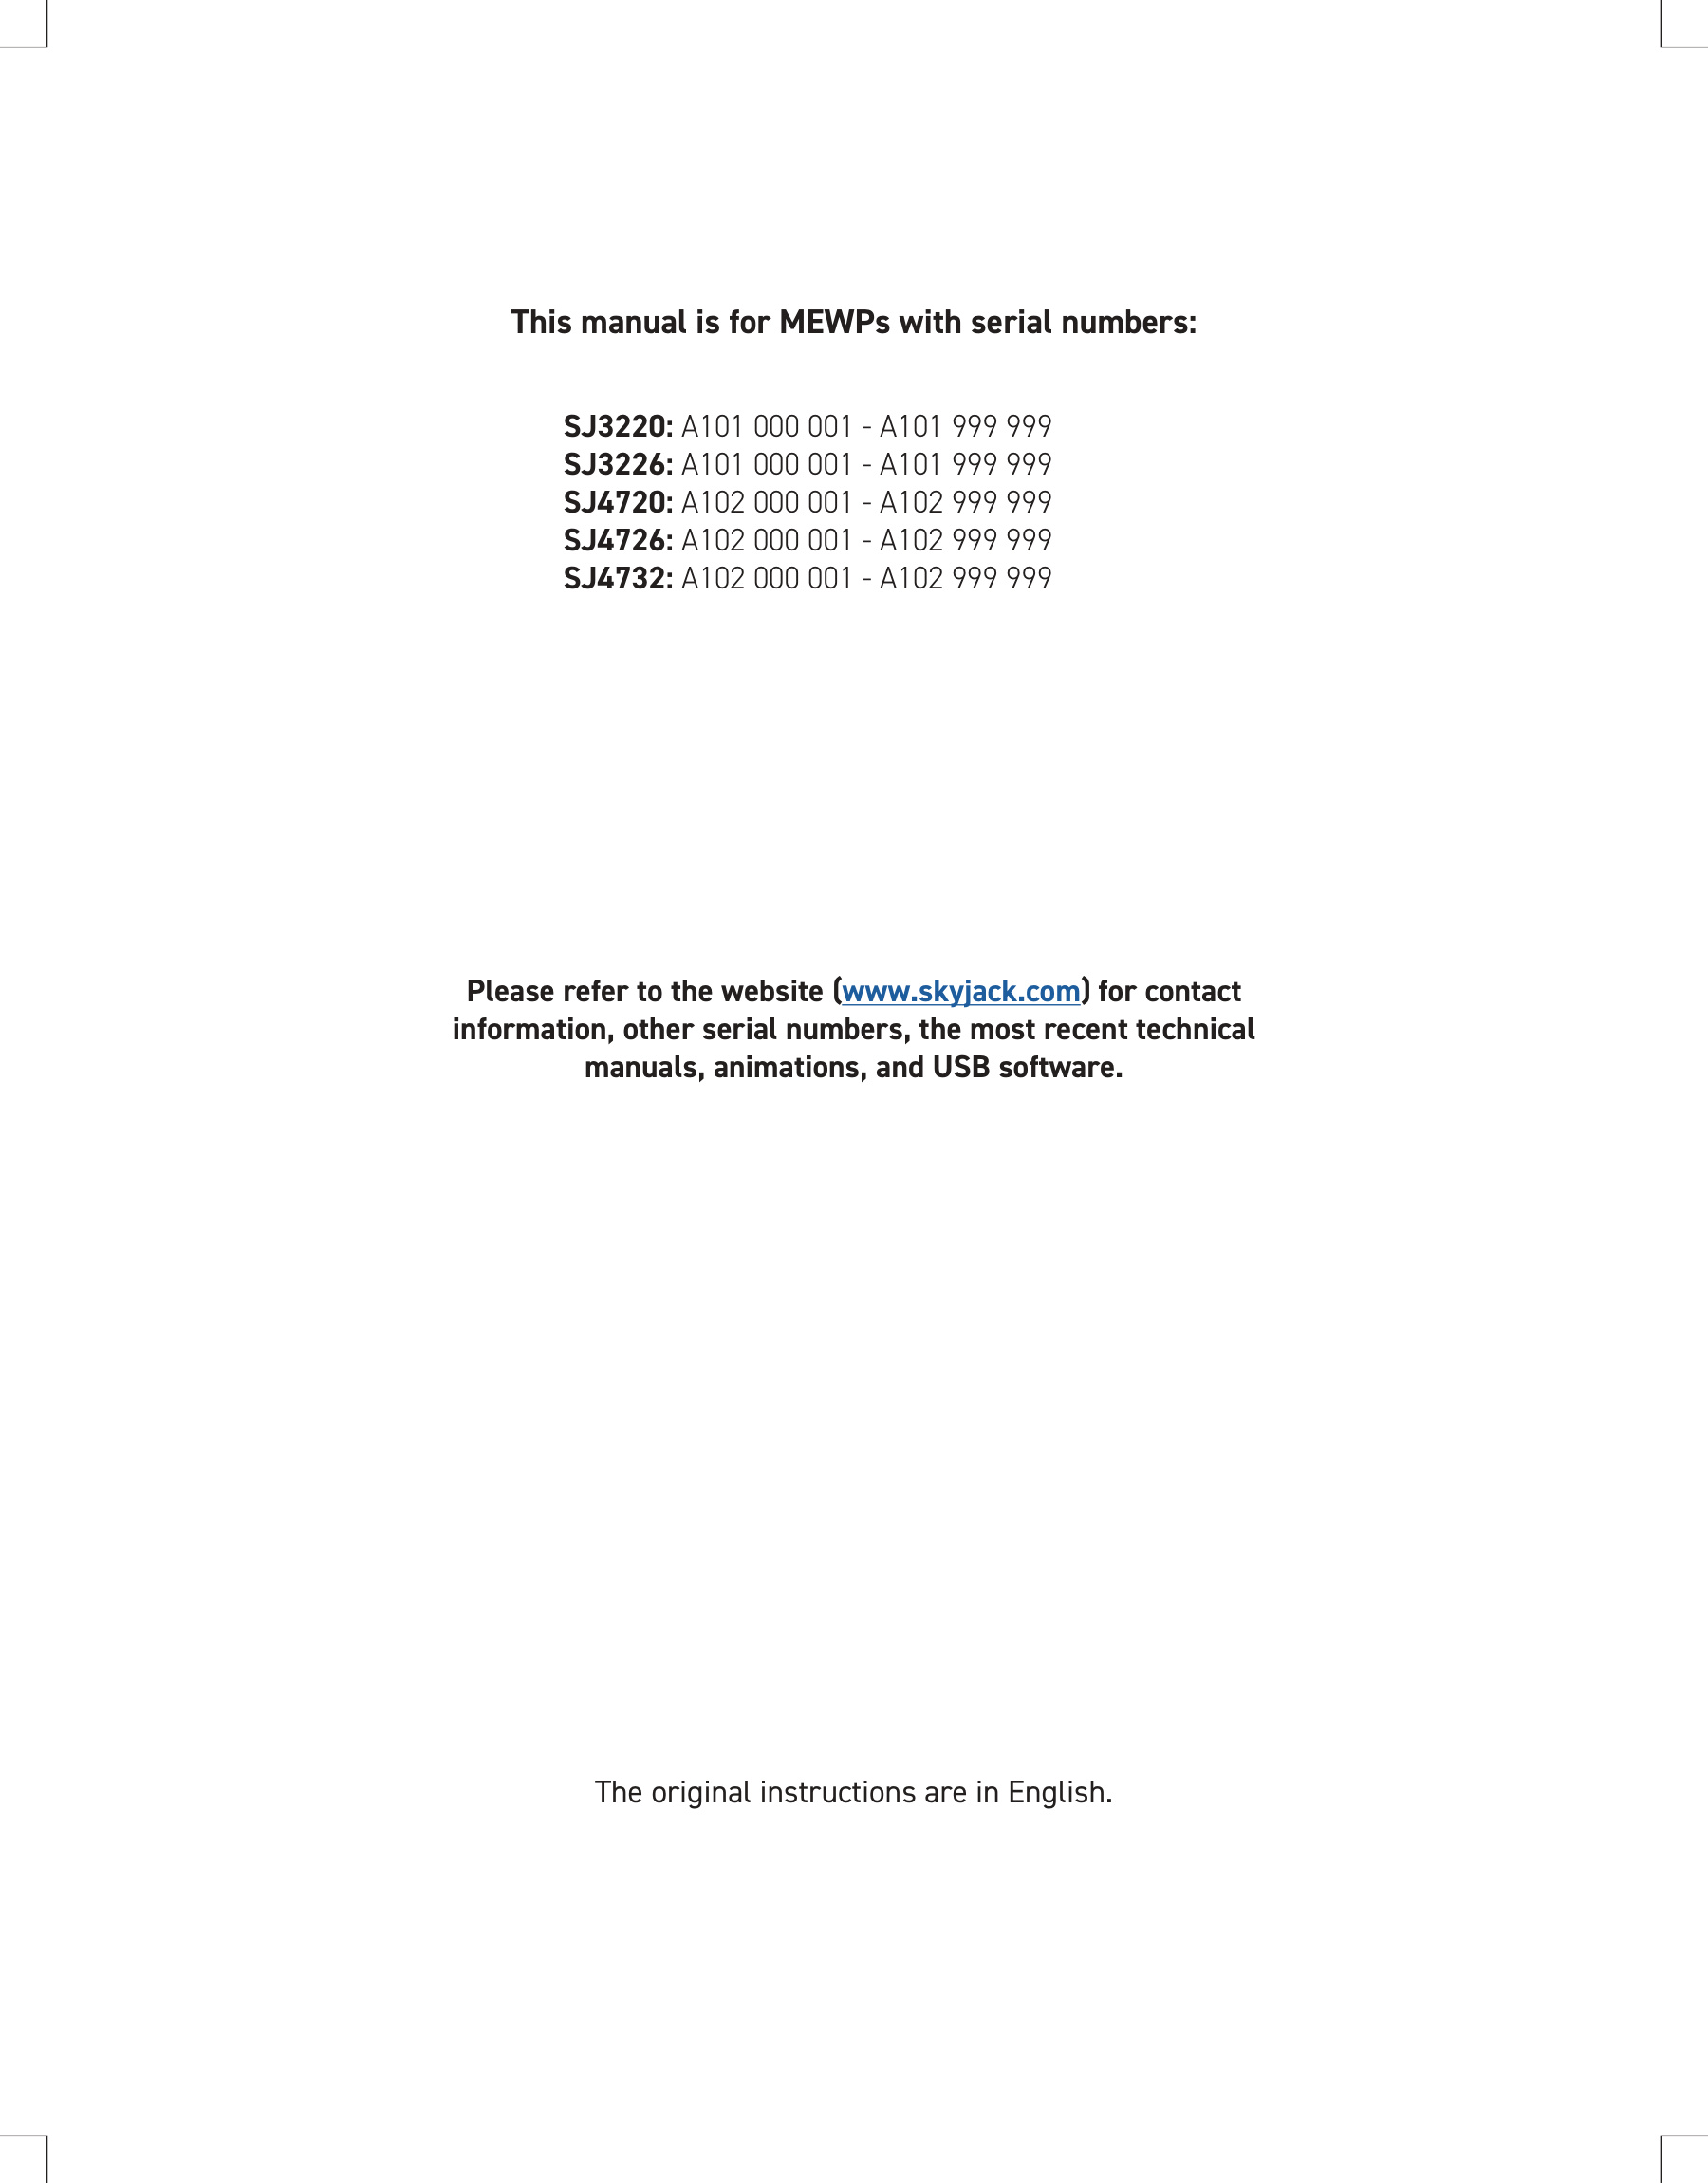

In [131]:
# Example usage
image_path = './image2.jpg'  # Specify the path to your image
base64_string = image_to_base64(image_path)
Image(filename=image_path) 

In [132]:
response_text_2 = interactWithLLM("show the content of the image as a JSON. The JSON should have the manual name, edition, date,  models(start and end as applicable) and serial number Range for the model (start and end as applicable), other details if NOT already in JSON",base64_string,model_id)
print('response_text --- \n' + response_text_2)

**THE LLM TYPE IS -->anthropic.claude-3-haiku-20240307-v1:0
The runtime of the invoke_model was 5.04 seconds.
response_text --- 
{
  "manualName": "This manual is for MEWPs with serial numbers:",
  "models": [
    {
      "model": "SJ3220",
      "serialNumberRange": {
        "start": "A101 000 001",
        "end": "A101 999 999"
      }
    },
    {
      "model": "SJ3226",
      "serialNumberRange": {
        "start": "A101 000 001",
        "end": "A101 999 999"
      }
    },
    {
      "model": "SJ4720",
      "serialNumberRange": {
        "start": "A102 000 001",
        "end": "A102 999 999"
      }
    },
    {
      "model": "SJ4726",
      "serialNumberRange": {
        "start": "A102 000 001",
        "end": "A102 999 999"
      }
    },
    {
      "model": "SJ4732",
      "serialNumberRange": {
        "start": "A102 000 001",
        "end": "A102 999 999"
      }
    }
  ],
  "otherDetails": "Please refer to the website (www.skyjack.com) for contact information, other 

In [133]:
def interactWithLLM_text(prompt, modelId):
    # if llm_type == 'anthropic.claude-3-sonnet':
    print("**THE LLM TYPE IS -->" + modelId)
    body = json.dumps({
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 1000,
        "temperature": 0,
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ]
    })
    # modelId = 'anthropic.claude-3-sonnet-20240229-v1:0' # change this to use a different version from the model provider
    accept = 'application/json'
    contentType = 'application/json'
    start_time = time.time()
    response = bedrock_client.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    # Record the end time
    end_time = time.time()

    # Calculate the runtime
    runtime = end_time - start_time
    print(f"The runtime of the invoke_model was {runtime:.2f} seconds.")

    response_body = json.loads(response.get('body').read())
    response_text = response_body.get('content')[0]['text']

    return response_text

In [134]:
response_text = interactWithLLM_text("combine as JSON and remove any duplicates "+response_text_1 + response_text_2,model_id)
print('response_text --- \n' + response_text)

**THE LLM TYPE IS -->anthropic.claude-3-haiku-20240307-v1:0
The runtime of the invoke_model was 3.87 seconds.
response_text --- 
{
  "manualName": "Service Manual",
  "edition": "223198AEA",
  "date": "November 9 2023",
  "standards": [
    "ANSI/CSA",
    "CE",
    "AS",
    "KC"
  ],
  "serialNumberRange": {
    "start": "SJ3220",
    "end": "SJ4732"
  },
  "models": [
    {
      "model": "SJ3220",
      "serialNumberRange": {
        "start": "A101 000 001",
        "end": "A101 999 999"
      }
    },
    {
      "model": "SJ3226",
      "serialNumberRange": {
        "start": "A101 000 001",
        "end": "A101 999 999"
      }
    },
    {
      "model": "SJ4720",
      "serialNumberRange": {
        "start": "A102 000 001",
        "end": "A102 999 999"
      }
    },
    {
      "model": "SJ4726",
      "serialNumberRange": {
        "start": "A102 000 001",
        "end": "A102 999 999"
      }
    },
    {
      "model": "SJ4732",
      "serialNumberRange": {
        "start

In [102]:
!ls -altr

total 23376
drwx------  2 root     root       16384 Mar 26 16:37 lost+found
drwxr-xr-x  2 ec2-user ec2-user    4096 Mar 26 16:37 .sparkmagic
drwx------ 20 ec2-user ec2-user    4096 Mar 26 16:37 ..
drwxrwxr-x  2 ec2-user ec2-user    4096 Mar 26 16:52 .virtual_documents
-rw-rw-r--  1 ec2-user ec2-user  106742 Mar 26 16:55 org_chart.jpeg
-rw-rw-r--  1 ec2-user ec2-user  923792 Mar 26 16:55 school_notes.png
-rw-rw-r--  1 ec2-user ec2-user  584872 Mar 26 16:55 samp1.png
drwx------  4 ec2-user ec2-user    4096 Mar 26 16:55 .Trash-1000
-rw-rw-r--  1 ec2-user ec2-user 1381374 Mar 26 16:58 vehicle_form.jpeg
-rw-rw-r--  1 ec2-user ec2-user  130796 Mar 26 16:59 complex_page.jpeg
-rw-rw-r--  1 ec2-user ec2-user 4198387 Mar 26 17:03 image_to_text.ipynb
-rw-rw-r--  1 ec2-user ec2-user 7326973 Mar 26 17:04 Genie_manual.pdf
-rw-rw-r--  1 ec2-user ec2-user 8586020 Mar 26 17:04 skyjack_manual.pdf
-rw-rw-r--  1 ec2-user ec2-user  130139 Mar 26 22:21 image1.jpg
-rw-rw-r--  1 ec2-user ec2-user   34376 Mar 